# ResNet50 Retraining on custom dataset

### Import required packages

In [60]:
# supress the warnings
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import time
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.resnet50 import ResNet50, decode_predictions
from keras.models import Sequential, model_from_json
from keras.optimizers import RMSprop, sgd
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Dataset description
- The dataset contains four clasesss (cats, cats, horses, Humans)
- Each class has 200 images
- There are 800 images in the dataset
- 646 Images are used for training and 162 Images for testing

### Load custom training data

In [61]:
PATH = os.getcwd()
# custom data path
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)

img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset: '+'{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/'+ dataset + '/'+ img 
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        #print('Input image shape:', x.shape)
        img_data_list.append(x)
print('Input image shape (One Image) : ', x.shape)


Loaded the images of dataset: cats

Loaded the images of dataset: dogs

Loaded the images of dataset: horses

Loaded the images of dataset: Humans

Input image shape (One Image) :  (1, 224, 224, 3)


### Reshape the loaded images

In [62]:
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape) # (808, 1, 224, 224, 3)

img_data=np.rollaxis(img_data,1,0)
print (img_data.shape) # (1, 808, 224, 224, 3)

img_data=img_data[0]
print (img_data.shape) # (808, 224, 224, 3)

(808, 1, 224, 224, 3)
(1, 808, 224, 224, 3)
(808, 224, 224, 3)


### Split the dataset into training and testing

In [63]:
num_classes = 4
num_of_samples = img_data.shape[0]

labels = np.ones((num_of_samples,),dtype='int64')

labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

names = ['cats','dogs','horses','humans']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

# print train and test samples
print('Training samples: ', X_train.shape[0], 'Images')
print('Test samples: ', X_test.shape[0], 'Images')

Training samples:  646 Images
Test samples:  162 Images


### Create custom ResNet Model

In [64]:
# Fine tune the resnet 50
#image_input = Input(shape=(224, 224, 3))
model = ResNet50(weights='imagenet',include_top=False)
# uncomment the below line to display the summary of the model
#model.summary() # Original model with 1000 classes in final layer

last_layer = model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)

# add fully-connected & dropout layers
x = Dense(512, activation='relu',name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',name='fc-2')(x)
x = Dropout(0.5)(x)

# a softmax layer for 4 classes
out = Dense(num_classes, activation='softmax',name='output_layer')(x)

# this is the model we will train
custom_resnet_model2 = Model(inputs=model.input, outputs=out)

# uncomment the below line to display the summary of the model
custom_resnet_model2.summary() # Customized  model with 4 classes in final layer


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

### Freeze all the layer except the final

In [65]:
for layer in custom_resnet_model2.layers[:-1]:
	layer.trainable = False

custom_resnet_model2.layers[-1].trainable

custom_resnet_model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### Train customized model

In [66]:
t=time.time()
hist = custom_resnet_model2.fit(X_train, y_train, batch_size=64, epochs=1, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))

Train on 646 samples, validate on 162 samples
Epoch 1/1
646/646 [==============================] - 192s 297ms/step - loss: 1.9320 - acc: 0.2632 - val_loss: 1.3920 - val_acc: 0.3457
Training time: -191.9425003528595


### Test the trained model

In [67]:
(loss, accuracy) = custom_resnet_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))


162/162 [==============================] - 38s 234ms/step
[INFO] loss=1.3920, accuracy: 34.5679%


### Display training and testing accuracy

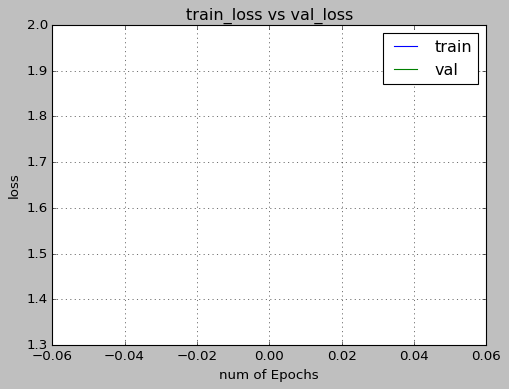

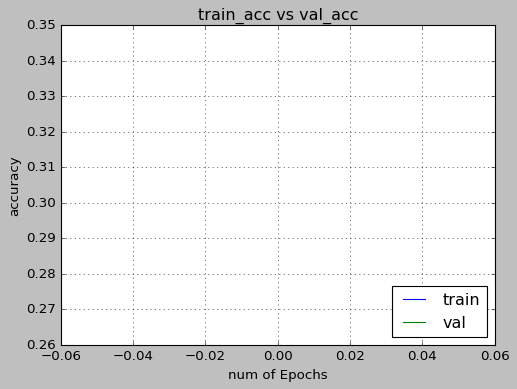

In [70]:
import matplotlib.pyplot as plt
#%matplotlib inline

# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(1) # number of epoches

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
#plt.show()

### Make prediction with unseen images

In [71]:
img_path = 'dog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = custom_resnet_model2.predict(x)
#print('Predicted:', decode_predictions(preds))

print('\nPrediction\n',preds)
print('\nThresholded output\n',(preds>0.5)*1)
#print('\nPredicted Digit:\n',np.where(prediction == 1)[1][0])

Input image shape: (1, 224, 224, 3)

Prediction
 [[0.14376743 0.4156115  0.3190977  0.12152337]]

Thresholded output
 [[0 0 0 0]]


### Ground truth

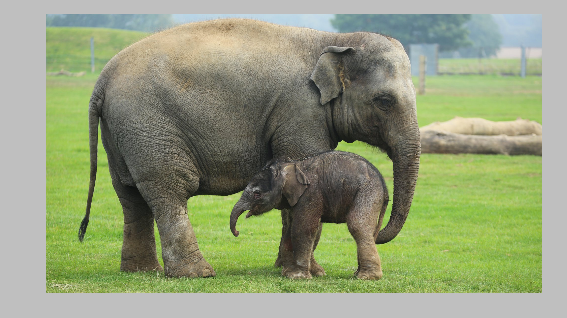

In [72]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load image in color
image_bgr = cv2.imread('elephant.jpg', cv2.IMREAD_COLOR)
# Convert to RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show image
plt.imshow(image_rgb), plt.axis("off")
plt.show()

### Save trained model and weights

In [74]:
# serialize model to JSON
model_json = custom_resnet_model2.to_json()

# Write the file name of the model

with open("ResNet50RetrainedModel.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
# Write the file name of the weights

model.save_weights("ResNet50RetrainedModel.h5")
print("Saved model to disk")

Saved model to disk
